In [7]:

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 

%matplotlib inline

## 1. Examining upstream 5'UTR Elements and MRL

In [8]:
################### Provided functions, you will not need to edit these ##################################3

def openDataset():
    #function for opening dataset after download 
    return pd.read_csv("mrl_dataset.csv")

def countCodonsInAllUTRs(df):
    #For each utr, count the number of atgs, ctgs, gtgs, and stops in each utr sequence
    #INPUT: dataframe of utr sequences to fill in
    #OUTPUT: dataframe with column for number of ATGs, number of CTGs, etc.
    df['NumberATGs'] = None
    df['NumberCTGs'] = None
    df['NumberGTGs'] = None
    df['NumberStops'] = None
    for ind, row in df.iterrows():
        startCounts, altStart1Counts, altStart2Counts, stopCounts = countCodonsInUTR(row['utr'])
        df.at[ind, 'NumberATGs'] = startCounts
        df.at[ind, 'NumberStops'] = stopCounts
        df.at[ind,'NumberCTGs'] = altStart1Counts
        df.at[ind,'NumberGTGs'] = altStart2Counts
    return df


def getStartPositionOfCodon(utr, codon):
    #for dataframe with one example of the codon- return the index of the codon relative to original start 
    #i.e., codon starting at index 0 in utr is -50 relative to the start, codon starting at 47 is -3 relative to original start
    for i in range(0, len(utr) - 2):
        #for each 3, mer check if it is the codon and return the position 
        if utr[i:i+3] == codon:
            return i - 50 #to get actual position relative to start 

def makePlot(x,y, title):
    #generates graphs 
    #input: x is positions relative to normal start, y is the mean MRL per position, title is the title for the graph
    dashPositions = [pos for pos in x if pos%3 == 0]
    #plotting in matplotlib, adding vertical dashes for IF positions
    plt.plot(x,y)
    for pos in dashPositions:
        plt.axvline(pos, color='g', linestyle='--')
    plt.title(title) #"IF and OOF ATG Effects on MRL"
    plt.xlabel("Position")
    plt.ylabel("MRL")
    plt.show()
    

### 1.1 Graphing the effects of upstream starts

In [20]:
################ You will need to edit these functions ############################

#here's some resources if you're stuck: 
#http://claresloggett.github.io/python_workshops/kmer_counting.html
#https://www.geeksforgeeks.org/find-average-list-python/

# Note: you will use this function to filter out sequences with multiple start codons; i.e. to simplify your analysis
#  you will only consider sequences with exactly 1 of the start codons under consideration (ATG, CTG, or GTG). For your
#  start codon analysis in 1.1, you will also filter out UTRs with upstream stop codons, again using the results of 
#  this function. And for 1.2, you will filter out UTRs with upstream stops.
def countCodonsInUTR(utr):
    """Counts occurences of ATG, CTG, GTG, and stop codons in a single 5' UTR sequence

    Args:
        utr (string): UTR sequence

    Returns:
        tuple of ints: count of ATG in sequence, count of CTG in sequence, count of GTG in sequence, count of stops in sequence
    """
    stops = ['TAA', 'TGA', 'TAG']
    start = "ATG"
    altStart1 = "CTG"
    altStart2 = "GTG"
    startCounts = 0
    altStart1Counts = 0
    altStart2Counts = 0
    stopCounts = 0
    #TODO: Count the number of times each start occurs in a utr and the number of time any stop occurs in a utr
    for i in range(len(utr) - 2):
        codon = utr[i:i+3]
        if (codon == stops[0] or codon == stops[1] or codon == stops[2]):
            stopCounts += 1
        elif (codon == start):
            startCounts += 1
        elif (codon == altStart1):
            altStart1Counts += 1
        elif (codon == altStart2):
            altStart2Counts += 1
    
    return startCounts, altStart1Counts, altStart2Counts, stopCounts


def meanMRL(df, colName):
    """Calculates position-wise MRL for some codon upstream of the start.

    Args:
        df (dataframe): Dataframe that contains a column called colName
        colName (string): Name of column in df containing the position at which some codon occurs

    Returns:
        list: MRL per position upstream of start codon (will be used for graphing); 48 elements long
    """ 
    output = []
    for i in range(-50, -2):
        sliceDfValues = df[df[colName] == i].rl.to_list() #list of all [\m]rl values for a codon starting at position i
        runningSum = 0
        for rl in sliceDfValues:
            runningSum += rl
        output.append(runningSum / len(sliceDfValues))
        #TODO: calculate MRL for each position i 
    return list(range(-50,-2)), output



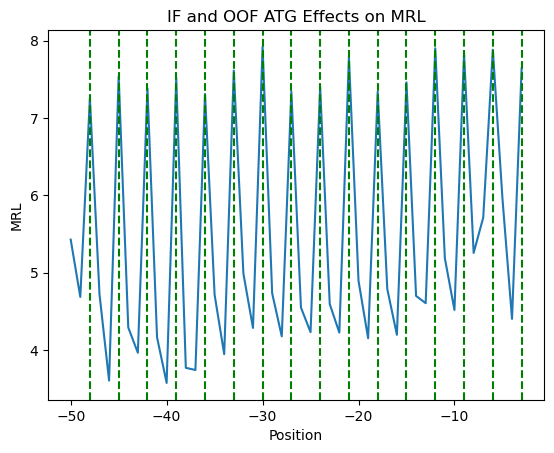

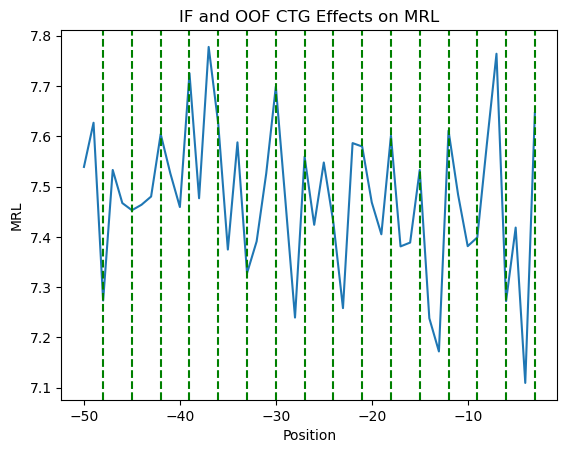

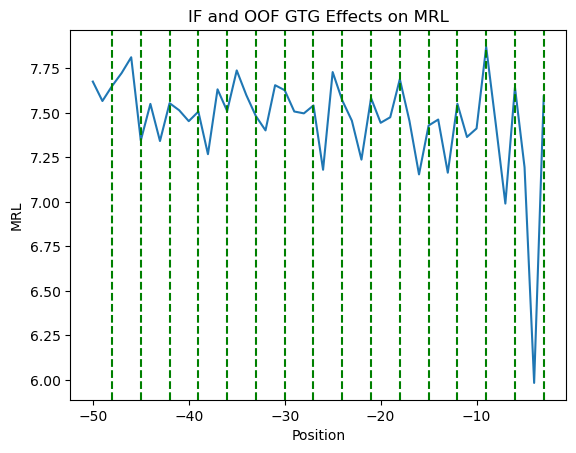

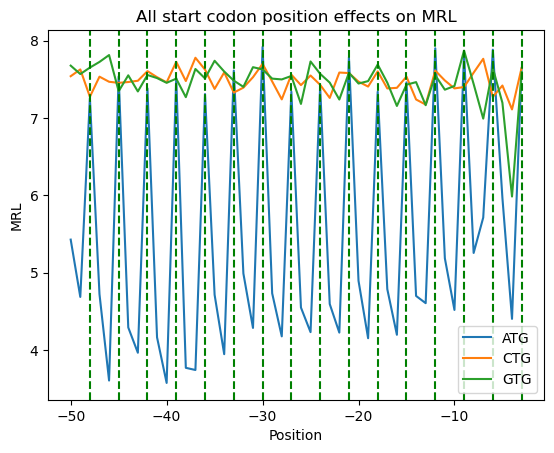

In [21]:
#1.1
################### Don't need to edit these, just run this cell ####################################

#OPEN DATASET
train= openDataset()
#We will be using the training set to graph mean MRL effects
#count # starts and stops in each UTR sequence
train = countCodonsInAllUTRs(train)

#ATGs
#Filter to just sequences with one upstream ATG, no stops
oneStartNoStops = train[(train['NumberATGs'] == 1) & (train['NumberCTGs'] == 0) & (train['NumberGTGs'] == 0) & (train['NumberStops'] == 0)].copy().reset_index(drop = True)
#find position where the start occurs 
oneStartNoStops['ATGPosition'] = oneStartNoStops['utr'].apply(lambda x: getStartPositionOfCodon(x, "ATG"))
#drop utrs with no ATG position found
oneStartNoStops = oneStartNoStops.dropna(subset = ['ATGPosition'])
#calculate mean MRL based on codon position
x, yATG = meanMRL(oneStartNoStops, 'ATGPosition')
#graph
makePlot(x,yATG, "IF and OOF ATG Effects on MRL")

#CTGs
#Filter to just sequences with one upstream CTG, no stops
oneStartNoStops = train[(train['NumberATGs'] == 0) & (train['NumberCTGs'] == 1) & (train['NumberGTGs'] == 0) & (train['NumberStops'] == 0)].copy().reset_index(drop = True)
oneStartNoStops['CTGPosition'] = oneStartNoStops['utr'].apply(lambda x: getStartPositionOfCodon(x, "CTG"))
oneStartNoStops = oneStartNoStops.dropna(subset = ['CTGPosition'])
x, yCTG = meanMRL(oneStartNoStops, 'CTGPosition') 
makePlot(x,yCTG, "IF and OOF CTG Effects on MRL")

#GTG
oneStartNoStops = train[(train['NumberATGs'] == 0) & (train['NumberCTGs'] == 0) & (train['NumberGTGs'] == 1) & (train['NumberStops'] == 0)].copy().reset_index(drop = True)
oneStartNoStops['GTGPosition'] = oneStartNoStops['utr'].apply(lambda x: getStartPositionOfCodon(x, "GTG"))
oneStartNoStops = oneStartNoStops.dropna(subset = ['GTGPosition'])
x, yGTG = meanMRL(oneStartNoStops, 'GTGPosition')
makePlot(x,yGTG, "IF and OOF GTG Effects on MRL")

#Plot all mean mrl based on starts on one graph 
dashPositions = [pos for pos in x if pos%3 == 0]
#plotting in matplotlib, adding vertical dashes for IF positions
plt.plot(x,yATG, label = "ATG")
plt.plot(x, yCTG, label = "CTG")
plt.plot(x, yGTG, label = "GTG")
for pos in dashPositions:
    plt.axvline(pos, color='g', linestyle='--')
plt.title("All start codon position effects on MRL") #"IF and OOF ATG Effects on MRL"
plt.xlabel("Position")
plt.ylabel("MRL")
plt.legend()
plt.show()


Summarize the effects of in frame vs. out of frame starts. Does this match what you would expect based on your knowledge of 5' UTRs? Answer in the markup cell below.

### 1.2 Graphing the effects of upstream stops

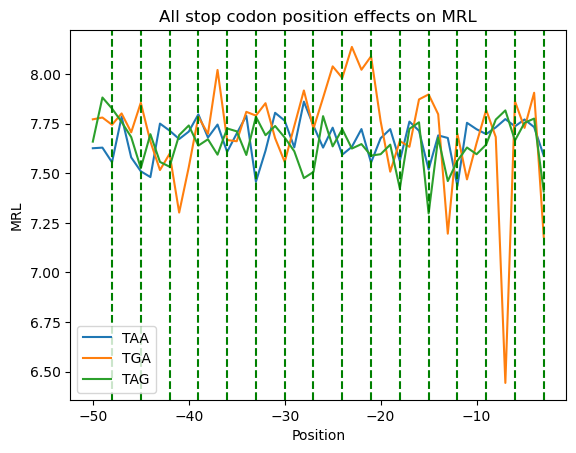

In [22]:
#1.2
################### Don't need to edit these, just run this cell ####################################

#Filter the dataframe to sequences with no upstream starts, 1 upstream stop 
oneStop = train[(train['NumberATGs'] == 0) & (train['NumberStops'] == 1) & (train['NumberGTGs'] == 0) & (train['NumberCTGs'] == 0)].copy().reset_index(drop = True)
#2) Find the position of each stop codon type
oneStop['stopPositionTAA'] = oneStop['utr'].apply(lambda x: getStartPositionOfCodon(x, "TAA"))
oneStop['stopPositionTGA'] = oneStop['utr'].apply(lambda x: getStartPositionOfCodon(x, "TGA"))
oneStop['stopPositionTAG'] = oneStop['utr'].apply(lambda x: getStartPositionOfCodon(x, "TAG"))
#3) Filter to sequences with a TAA
taa = oneStop.dropna(subset = ['stopPositionTAA'])
tga = oneStop.dropna(subset = ['stopPositionTGA'])
tag = oneStop.dropna(subset = ['stopPositionTAG'])
#4) Calculate the mean MRL based on upstream stop position  
x, yTAA = meanMRL(taa, "stopPositionTAA")
x, yTGA = meanMRL(tga, "stopPositionTGA")
x, yTAG = meanMRL(tag, "stopPositionTAG")
#5)Graph
dashPositions = [pos for pos in x if pos%3 == 0]
#plotting in matplotlib, adding vertical dashes for IF positions
plt.plot(x,yTAA, label = "TAA")
plt.plot(x, yTGA, label = "TGA")
plt.plot(x, yTAG, label = "TAG")
for pos in dashPositions:
    plt.axvline(pos, color='g', linestyle='--')
plt.title("All stop codon position effects on MRL") #"IF and OOF ATG Effects on MRL"
plt.xlabel("Position")
plt.ylabel("MRL")
plt.legend()
plt.show()


What effects on MRL do upstream stop codons appear to have (if any)? Does this match your expectations? Answer in the markup cell below.